In [1]:
import sys
sys.path.append('../src')

import typing as tp

import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from scipy.ndimage import rotate

from imutils import imsshow, imshow, center_crop, impreprocess, load_npy, imread, gray2gray3d
from data.convolution import convolve
from data.convertation import linrgbf_to_srgbf
from deconv.classic.wiener.wiener import wiener_gray
from deconv.neural.usrnet.predictor import USRNetPredictor
from deconv.neural.dwdn.predictor import DWDNPredictor
from deconv.neural.kerunc.predictor import KerUncPredictor
from services.psf_distorter import PSFDistorter
from metrics import psnr, ssim

plt.gray()

np.random.seed(8)

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

<Figure size 640x480 with 0 Axes>

In [2]:
def simulate_psf_rotation(psf: np.ndarray, angle: tp.Tuple[float, int]) -> np.ndarray:
    max_nonzero_elements_diff = 20
    max_nonzero_value = psf[psf > 0].max()  # number of non-zero elements in psf
    rotated_psf = rotate(psf, angle)
    
    # rotation produces many non-zero small elements, so we cut them off
    top_value = max_nonzero_value / 5
    rotated_psf[(rotated_psf > 0) & (rotated_psf < top_value)] = 0
    
    if psf.shape != rotated_psf.shape:
        diff_y = rotated_psf.shape[0] - psf.shape[0]
        diff_x = rotated_psf.shape[1] - psf.shape[1]
        rotated_psf = rotated_psf[(diff_y // 2):-(diff_y // 2 + diff_y % 2), (diff_x // 2):-(diff_x // 2 + diff_x % 2)]
    
    while abs(len(rotated_psf[rotated_psf > 0]) - len(psf[psf > 0])) > max_nonzero_elements_diff:
        top_value = top_value * 2
        rotated_psf[(rotated_psf > 0) & (rotated_psf < top_value)] = 0
    
    return rotated_psf / rotated_psf.sum() 

In [3]:
def build_rotation_grid(size: int, angle: tp.Tuple[int, float]) -> tp.List[tp.List[tp.Tuple[int, float]]]:
    grid_2d = []
    grid_row = []
    for i in range(size):
        for j in range(size):
            grid_row.append((i + j) * angle)
        grid_2d.append(grid_row)
        grid_row = []
    return grid_2d

In [4]:
build_rotation_grid(4, angle=5)

[[0, 5, 10, 15], [5, 10, 15, 20], [10, 15, 20, 25], [15, 20, 25, 30]]

In [5]:
def build_rotation_grid_v2(size: int, angle: tp.Tuple[int, float]) -> tp.List[tp.List[tp.Tuple[int, float]]]:
    grid_2d = []
    grid_row = []
    for i in range(size):
        for j in range(size):
            grid_row.append(j * angle)
        grid_2d.append(grid_row)
        grid_row = []
    return grid_2d

In [6]:
build_rotation_grid_v2(4, angle=5)

[[0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15], [0, 5, 10, 15]]

In [7]:
def non_uniform_convolution(
    image: np.ndarray,
    psf: np.ndarray,
    num_rotations_per_row: int,
    angle: int,
    grid_version: tp.Literal['v1', 'v2']
) -> np.ndarray:
    
    image_height, image_width = image.shape
    psf_height, psf_width = psf.shape
    
    pad_height = psf_height // 2
    pad_width = psf_width // 2
    
    # Pad the image
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='symmetric')
    padded_height, padded_width = padded_image.shape
    
    convolved_image = np.zeros_like(image)
    
    if grid_version == 'v1':
        rotation_grid = build_rotation_grid(num_rotations_per_row, angle)
    elif grid_version == 'v2':
        rotation_grid = build_rotation_grid_v2(num_rotations_per_row, angle)
    
    i = 0
    angle = 0
    psf_rotated = psf.copy()
    shift = image_height // num_rotations_per_row
    
    for y in range(image_height):
        for x in range(image_width):
            if rotation_grid[x // shift][y // shift] != angle:
                angle = rotation_grid[x // shift][y // shift]
                psf_rotated = simulate_psf_rotation(psf, angle)
            convolved_image[y, x] = np.sum(padded_image[y:y+psf_height, x:x+psf_width] * psf_rotated)
            i += 1
    
    return convolved_image

In [8]:
image = impreprocess('../datasets/gt/Sun-gray/im_10.png', crop=True)
psf = load_npy('../datasets/kernels/motion-blur/processed/synthetic/synthetic-2.npy', key='psf')

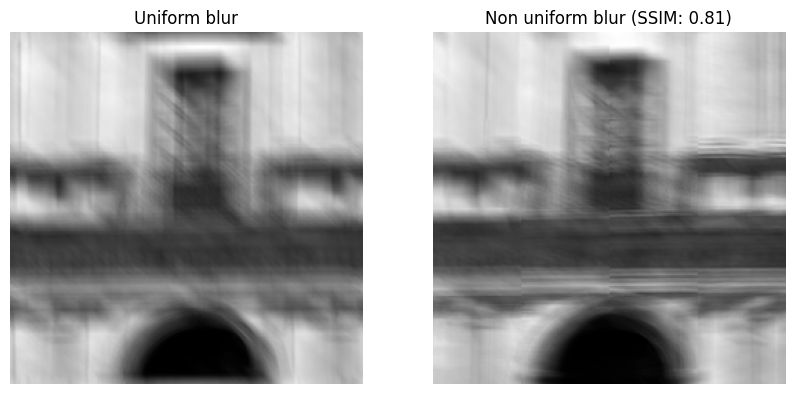

In [9]:
non_uniform_image = non_uniform_convolution(image, psf, num_rotations_per_row=4, angle=10, grid_version='v1')
uniform_image = convolve(image, psf).astype(np.float32)


imsshow([uniform_image, non_uniform_image], titles=['Uniform blur', f'Non uniform blur (SSIM: {ssim(uniform_image, non_uniform_image):.2f})'], figsize=(10, 10))

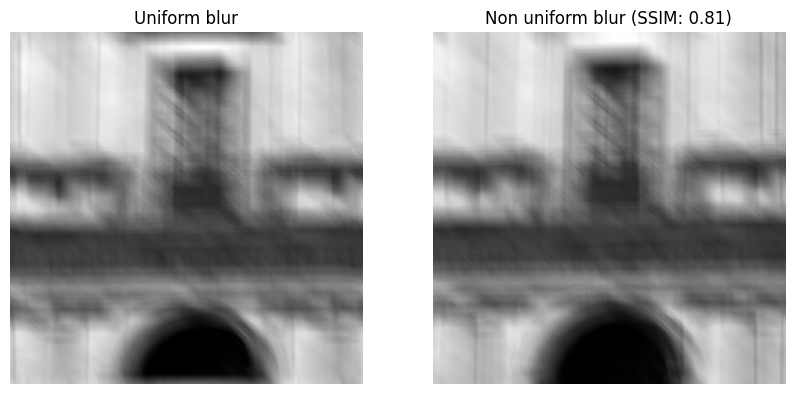

In [10]:
non_uniform_image = non_uniform_convolution(image, psf, num_rotations_per_row=4, angle=0, grid_version='v2')
uniform_image = convolve(image, psf).astype(np.float32)


imsshow([uniform_image, non_uniform_image], titles=['Uniform blur', f'Non uniform blur (SSIM: {ssim(uniform_image, non_uniform_image):.2f})'], figsize=(10, 10))

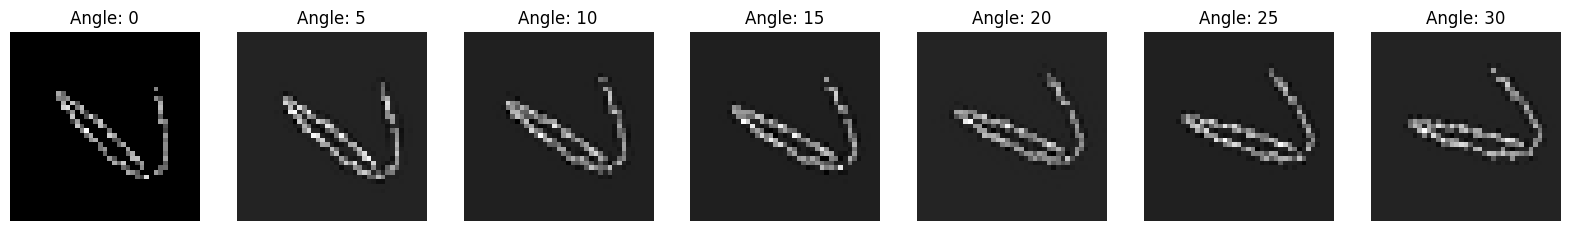

In [11]:
imsshow(
    [simulate_psf_rotation(psf, angle) for angle in range(0, 35, 5)],
    titles=[f'Angle: {angle}' for angle in range(0, 35, 5)],
    figsize=(20, 5),
)

# Vizualization

In [12]:
def _1d_t0_3d(image: np.ndarray) -> np.ndarray:
    return np.dstack([image for _ in range(3)])


def viz(
    image: np.ndarray,
    psf: np.ndarray,
    blurred: np.ndarray,
    blurred_3d: np.ndarray,
    non_uniform_blurred: np.ndarray,
    non_uniform_blurred_3d: np.ndarray,
    models: dict,
    is_noised: bool,
    is_srgb: bool,
):
    if is_srgb:
        viz_preprocess = lambda image: linrgbf_to_srgbf(_1d_t0_3d(image))
    else:
        viz_preprocess = lambda image: _1d_t0_3d(image)

    _, ax = plt.subplots(3, 4, figsize=(12, 10))

    ax[0, 0].imshow(psf)
    ax[0, 0].axis('off')
    ax[0, 0].set_title('PSF')

    ax[0, 1].imshow(viz_preprocess(blurred))
    ax[0, 1].axis('off')
    ax[0, 1].set_title(f'Uniform blurred')

    ax[0, 2].imshow(viz_preprocess(non_uniform_blurred))
    ax[0, 2].axis('off')
    ax[0, 2].set_title('Non-uniform blurred')

    ax[0, 3].imshow(viz_preprocess(image))
    ax[0, 3].axis('off')
    ax[0, 3].set_title(f'Original image')

    noise = 'noise' if is_noised else 'no_noise'
    for i, model_name in enumerate(models.keys()):
        model = models[model_name][noise]
        
        restored = (
            model(blurred_3d, psf)[..., 0]
            if model_name in ['usrnet', 'dwdn']
            else model(blurred, psf)
        )
        restored = np.clip(restored, 0, 1)
        
        ax[1, i].imshow(viz_preprocess(restored))
        ax[1, i].axis('off')
        ax[1, i].set_title(f'{model_name}\nssim: {ssim(image, restored):.2f}, psnr: {psnr(image, restored):.2f}')
    
        restored = (
            model(non_uniform_blurred_3d, psf)[..., 0]
            if model_name in ['usrnet', 'dwdn']
            else model(non_uniform_blurred, psf)
        )
        restored = np.clip(restored, 0, 1)
        
        ax[2, i].imshow(viz_preprocess(restored))
        ax[2, i].axis('off')
        ax[2, i].set_title(f'{model_name}\nssim: {ssim(image, restored):.2f}, psnr: {psnr(image, restored):.2f}')

 
####

def get_image_psf(
    image_path: str,
    psf_path: str,
    crop: bool,
    is_noised: bool,
    **non_uniform_conv_params,
) -> tp.Tuple[np.array, np.array, np.array, np.array]:
    """Returns GRAY image in specified discretization"""

    image = impreprocess(image_path, crop=crop)
    psf = load_npy(psf_path, key='psf')

    mu = 0
    sigma = 0.01

    # blurred
    blurred = convolve(image, psf)
    blurred_3d = gray2gray3d(blurred)

    non_uniform_blurred = non_uniform_convolution(image, psf, **non_uniform_conv_params)
    non_uniform_blurred_3d = gray2gray3d(non_uniform_blurred)
    
    if is_noised:
        blurred = make_noised(blurred, mu=mu, sigma=sigma)
        blurred_3d = make_noised(blurred_3d, mu=mu, sigma=sigma)
        
        non_uniform_blurred = make_noised(non_uniform_blurred, mu=mu, sigma=sigma)
        non_uniform_blurred_3d = make_noised(non_uniform_blurred_3d, mu=mu, sigma=sigma)
    
    if non_uniform_blurred.min() < 0:
        non_uniform_blurred = np.clip(non_uniform_blurred, 0, 1)
        non_uniform_blurred_3d = np.clip(non_uniform_blurred_3d, 0, 1)

    return image, psf, blurred, blurred_3d, non_uniform_blurred, non_uniform_blurred_3d

In [13]:
config = OmegaConf.load('../configs/config_viz_cuda.yml')
cm = config.models

models = dict()

models['wiener'] = dict()
models['wiener']['noise'] = lambda image, psf: wiener_gray(image, psf, **cm.wiener_nonblind_noise.noise_params)
models['wiener']['no_noise'] = lambda image, psf: wiener_gray(image, psf, **cm.wiener_nonblind_noise.no_noise_params)

models['kerunc'] = dict()
models['kerunc']['noise'] = KerUncPredictor(**cm.kerunc.noise_params)
models['kerunc']['no_noise'] = KerUncPredictor(**cm.kerunc.no_noise_params)

models['usrnet'] = dict()
models['usrnet']['noise'] = USRNetPredictor(model_path=cm.usrnet.model_path, **cm.usrnet.noise_params)
models['usrnet']['no_noise'] = USRNetPredictor(model_path=cm.usrnet.model_path, **cm.usrnet.no_noise_params)

models['dwdn'] = dict()
models['dwdn']['noise'] = DWDNPredictor(model_path=cm.dwdn.model_path, **cm.dwdn.noise_params)
models['dwdn']['no_noise'] = DWDNPredictor(model_path=cm.dwdn.model_path, **cm.dwdn.no_noise_params)


In [14]:
NUM_ROTATAIONS_PER_ROW = 4
ANGLE = 3
GRID_VERSION = 'v1'

###  1 

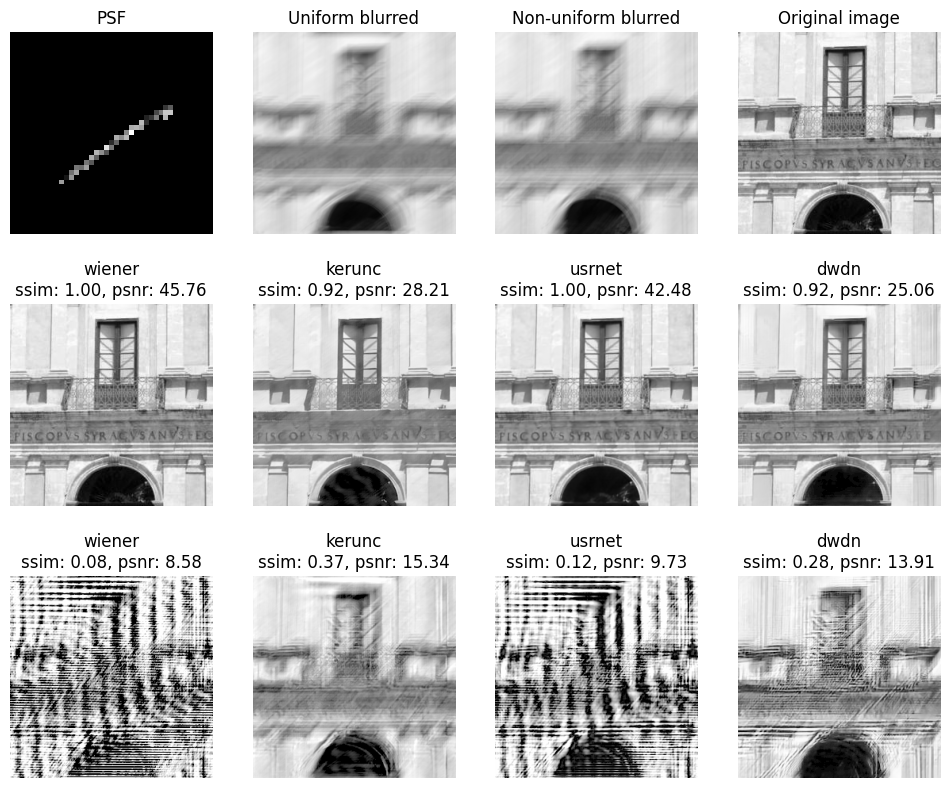

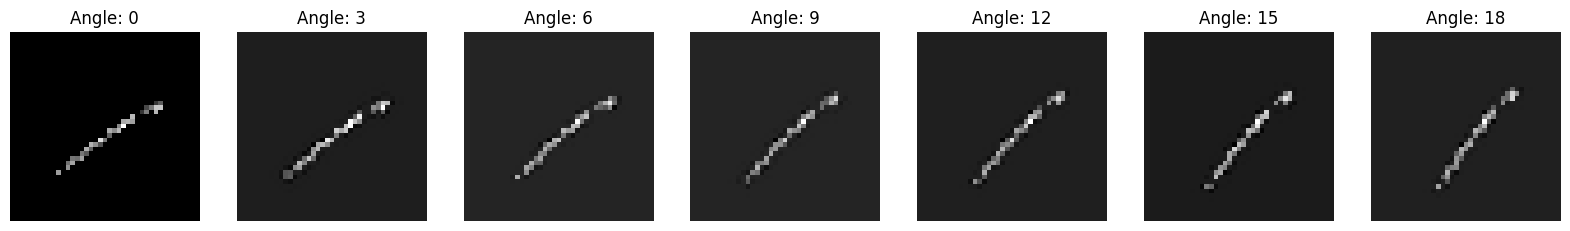

In [15]:
IS_NOISED = False

image, psf, blurred, blurred_3d, non_uniform_blurred, non_uniform_blurred_3d = get_image_psf(
    image_path='../datasets/gt/Sun-gray/im_10.png',
    psf_path='../datasets/kernels/motion-blur/processed/synthetic/synthetic-4.npy',
    is_noised=IS_NOISED,
    crop=True,
    num_rotations_per_row=NUM_ROTATAIONS_PER_ROW,
    angle=ANGLE,
    grid_version=GRID_VERSION,
)


viz(image, psf, blurred, blurred_3d, non_uniform_blurred, non_uniform_blurred_3d, models, is_noised=IS_NOISED, is_srgb=True)

imsshow(
    [simulate_psf_rotation(psf, angle) for angle in range(0, ANGLE * (NUM_ROTATAIONS_PER_ROW + 3), ANGLE)],
    titles=[f'Angle: {angle}' for angle in range(0, ANGLE * 7, ANGLE)],
    figsize=(20, 5),
)

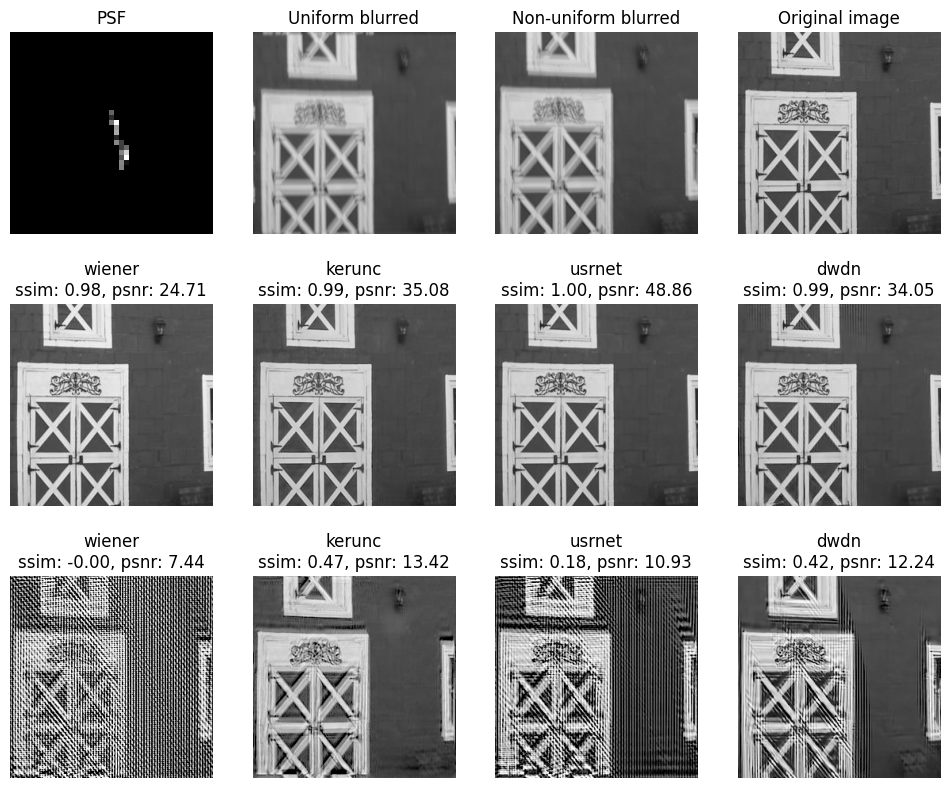

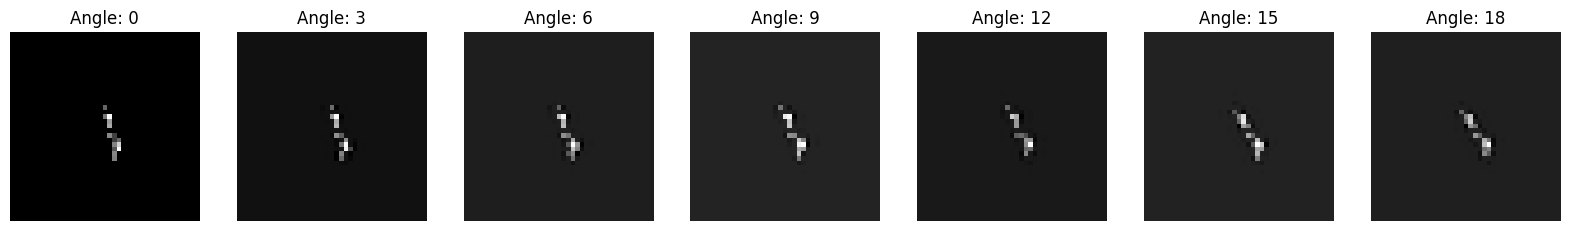

In [16]:
IS_NOISED = False

image, psf, blurred, blurred_3d, non_uniform_blurred, non_uniform_blurred_3d = get_image_psf(
    image_path='../datasets/gt/Sun-gray/im_5.png',
    psf_path='../datasets/kernels/motion-blur/processed/synthetic/synthetic-8.npy',
    is_noised=IS_NOISED,
    crop=True,
    num_rotations_per_row=NUM_ROTATAIONS_PER_ROW,
    angle=ANGLE,
    grid_version=GRID_VERSION,
)


viz(image, psf, blurred, blurred_3d, non_uniform_blurred, non_uniform_blurred_3d, models, is_noised=IS_NOISED, is_srgb=True)

imsshow(
    [simulate_psf_rotation(psf, angle) for angle in range(0, ANGLE * 7, ANGLE)],
    titles=[f'Angle: {angle}' for angle in range(0, ANGLE * 7, ANGLE)],
    figsize=(20, 5),
)

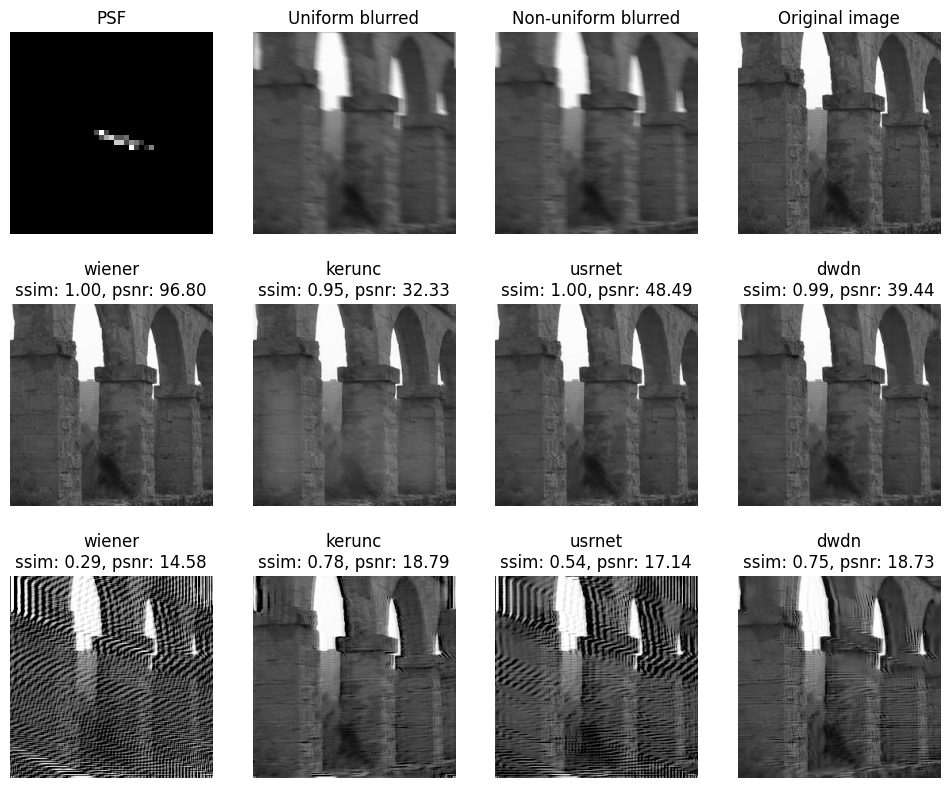

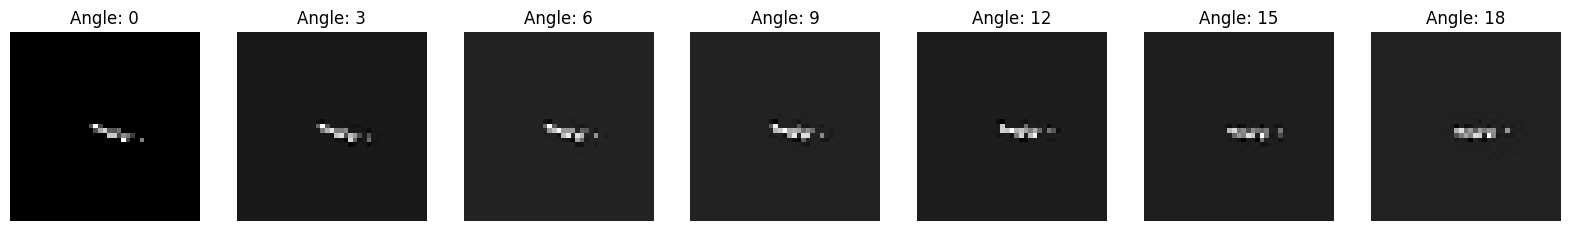

In [17]:
IS_NOISED = False

image, psf, blurred, blurred_3d, non_uniform_blurred, non_uniform_blurred_3d = get_image_psf(
    image_path='../datasets/gt/Sun-gray/im_2.png',
    psf_path='../datasets/kernels/motion-blur/processed/synthetic/synthetic-10.npy',
    is_noised=IS_NOISED,
    crop=True,
    num_rotations_per_row=NUM_ROTATAIONS_PER_ROW,
    angle=ANGLE,
    grid_version=GRID_VERSION,
)


viz(image, psf, blurred, blurred_3d, non_uniform_blurred, non_uniform_blurred_3d, models, is_noised=IS_NOISED, is_srgb=True)

imsshow(
    [simulate_psf_rotation(psf, angle) for angle in range(0, ANGLE * 7, ANGLE)],
    titles=[f'Angle: {angle}' for angle in range(0, ANGLE * 7, ANGLE)],
    figsize=(20, 5),
)

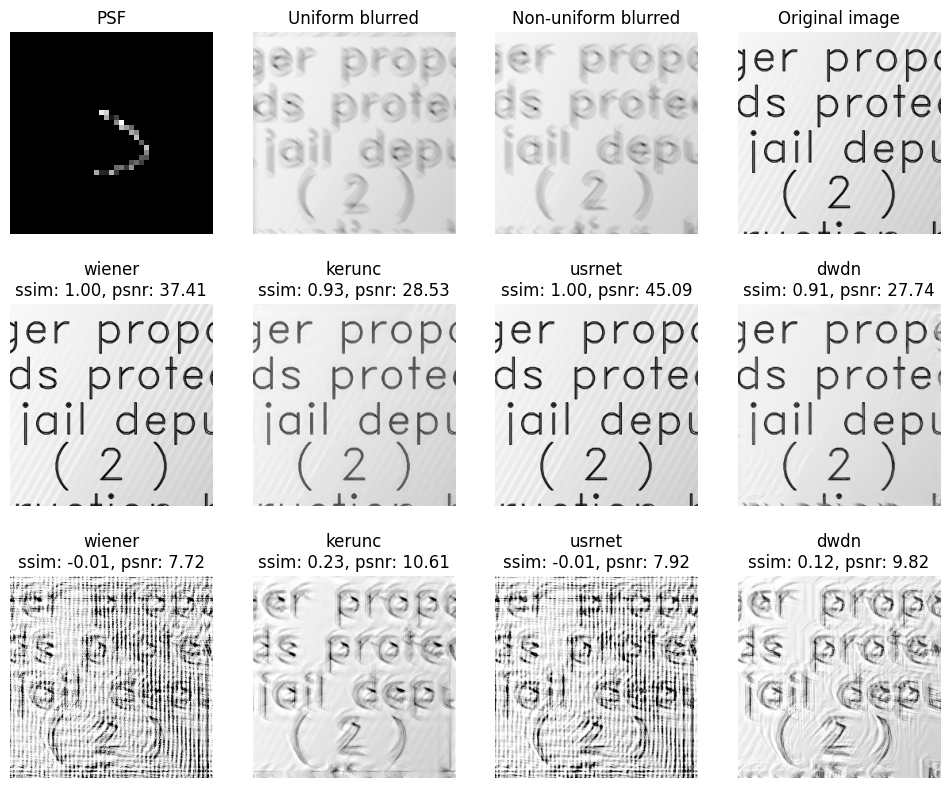

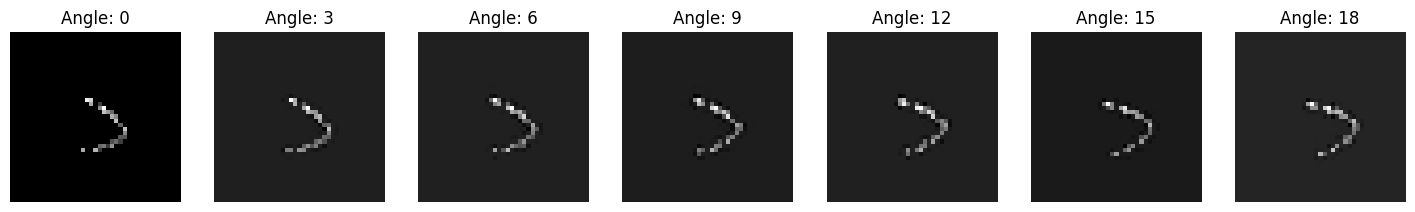

In [18]:
IS_NOISED = False

image, psf, blurred, blurred_3d, non_uniform_blurred, non_uniform_blurred_3d = get_image_psf(
#     image_path='../datasets/gt/Sun-gray/im_33.png',
    image_path='../datasets/gt/precomp/texts/_6_0.jpg',
    psf_path='../datasets/kernels/motion-blur/processed/synthetic/synthetic-13.npy',
    is_noised=IS_NOISED,
    crop=True,
    num_rotations_per_row=NUM_ROTATAIONS_PER_ROW,
    angle=ANGLE,
    grid_version=GRID_VERSION,
)


viz(image, psf, blurred, blurred_3d, non_uniform_blurred, non_uniform_blurred_3d, models, is_noised=IS_NOISED, is_srgb=True)

imsshow(
    [simulate_psf_rotation(psf, angle) for angle in range(0, ANGLE * 7, ANGLE)],
    titles=[f'Angle: {angle}' for angle in range(0, ANGLE * 7, ANGLE)],
    figsize=(18, 5),
)

In [19]:
rotation_grid = build_rotation_grid(4, angle=5)
psfs_rotated = []

for y_angle in range(4):
    psfs_rotated.append([simulate_psf_rotation(psf, angle=rotation_grid[x_angle][y_angle]) for x_angle in range(4)])

In [20]:
len(rotation_grid[0])

4

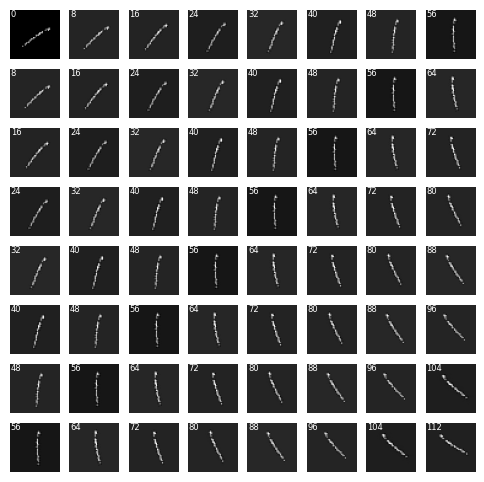

In [21]:
num_rotations = 8
rotation_grid = build_rotation_grid(num_rotations, angle=8)
psf = load_npy('../datasets/kernels/motion-blur/processed/synthetic/synthetic-4.npy', key='psf')

fig, axs = plt.subplots(num_rotations, num_rotations, figsize=(6, 6))

for i in range(num_rotations):
    for j in range(num_rotations):
        axs[i, j].imshow(simulate_psf_rotation(psf, angle=rotation_grid[i][j]))
        axs[i, j].axis('off')
        axs[i, j].text(0, 5, s=f'{rotation_grid[i][j]}', fontsize=6, color='white')

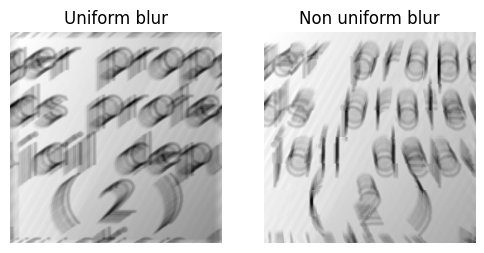

In [22]:
image = impreprocess('../datasets/gt/precomp/texts/_6_0.jpg', crop=True)

non_uniform_image = non_uniform_convolution(image, psf, num_rotations_per_row=8, angle=8, grid_version='v1')
uniform_image = convolve(image, psf).astype(np.float32)


imsshow([uniform_image, non_uniform_image], titles=['Uniform blur', f'Non uniform blur'], figsize=(6, 6))

### Test

In [23]:
rotation_grid = build_rotation_grid(4, angle=5)
rotation_grid

[[0, 5, 10, 15], [5, 10, 15, 20], [10, 15, 20, 25], [15, 20, 25, 30]]

In [24]:
prev_el = -1
for y in range(256):
    for x in range(256):
        if rotation_grid[x // 64][y // 64] != prev_el and y % 64 ==0:
            prev_el = rotation_grid[x // 64][y // 64]
            print(x, y, prev_el)

0 0 0
64 0 5
128 0 10
192 0 15
0 64 5
64 64 10
128 64 15
192 64 20
0 128 10
64 128 15
128 128 20
192 128 25
0 192 15
64 192 20
128 192 25
192 192 30
